<h1> Imports

In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt 
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFdr
from scipy.signal import butter, lfilter, filtfilt, freqz
from scipy import signal

<h1> Fitlering Functions

In [2]:
from joblib import dump, load

def pca_and_inverse(df, val=False, retain=0.95):
    if not val:
        print("Fit and save PCA")
        pca = PCA(retain).fit(df)
        dump(pca, 'models\\pca')
    else:
        print("Load PCA")
        pca = load('models\\pca')
    components = pca.transform(df)
    return pca.inverse_transform(components)

In [404]:
record_export_folder = 'recordings'
# keep_cols = ['EEG.P7', 'EEG.O1', 'EEG.O2', 'EEG.P8'] # ['Timestamp', 'EEG.Counter', 'EEG.P7', 'EEG.O1', 'EEG.O2', 'EEG.P8']
keep_cols = ["O1/theta","O1/alpha","O1/betaL","O1/betaH","O1/gamma",
             "O2/theta","O2/alpha","O2/betaL","O2/betaH","O2/gamma"]
keep_cols = ["O1/betaL","O1/betaH",
             "O2/betaL","O2/betaH"]

def load_df(file_name):
    file_path = os.path.join(record_export_folder, file_name)
    return pd.read_csv(file_path, skiprows=0, header=0)

def trim_cols(df):
    return df[keep_cols]

<h1> Data from 4 Sensors

In [405]:
df = trim_cols(load_df('psychopy_sultan_recording_{}.csv'.format(0)))

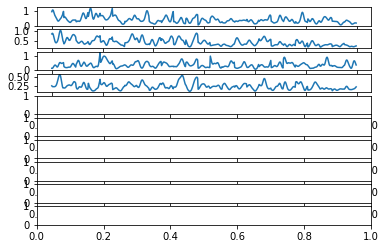

In [408]:
subplot = 0
fig, axs = plt.subplots(10)
for col in df.columns:
    axs[subplot].plot(df[col].values)
    subplot += 1

Fit and save PCA


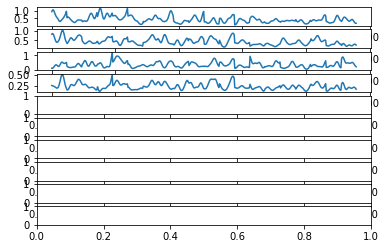

In [410]:
pca_df = pca_and_inverse(df[:480])
subplot = 0
fig, axs = plt.subplots(10)
for col in range(pca_df.shape[1]):
    axs[subplot].plot(pca_df[:,col])
    subplot += 1

Load PCA


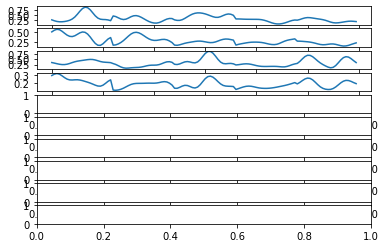

In [411]:
pca_df = pca_and_inverse(df[480:], True)
subplot = 0
fig, axs = plt.subplots(10)
for col in range(pca_df.shape[1]):
    axs[subplot].plot(pca_df[:,col])
    subplot += 1

<h1> Training Data

In [412]:
from sklearn.preprocessing import minmax_scale

In [556]:
seconds_to_check = 3
total_data_points = 600
interval_range = int(8 * seconds_to_check)
data_points = int(total_data_points / interval_range)

def split_to_training_data(df):
    total_data = []
    for interval_start in range(0, len(df), interval_range):
        temp_data = []
        for col in range(0, df.shape[1]):
            temp_data.append(df[interval_start:interval_start + interval_range, col])
        
        total_data.append(temp_data)
        
    return np.asarray(total_data)

def create_target_data(data, target):
    return np.asarray([target] * data.shape[0])

def create_target_data_by_size(size, target):
    return np.asarray([target] * size)
    
def scale_and_normalize(data):
    print(data.shape)
    for sample in range(data.shape[0]):
        for col in range(data.shape[1]):
            data[sample,col,:] = minmax_scale(data[sample,col,:])
#         for feature in range(data.shape[1]):
#             data[sample,feature,:] = minmax_scale(data[sample,feature,:])
#             data[:,col] = minmax_scale(data[:,col])
    return data
#     return minmax_scale(data)

In [624]:
targets = range(0, 4)
total_train_x = []
total_validate_x = []
total_train_y = []
total_validate_y = []
for target in targets:
    df = trim_cols(load_df('psychopy_sultan_recording_{}.csv'.format(target)))
    total_data = np.asarray(df.values)
    
    
    labels = create_target_data_by_size(data_points, target)
    train_y = labels[:20]
    validation_y = labels[20:]
    
    
    train_x = total_data[:480]
    validation_x = total_data[480:]
    
    
    if target == targets[0]:
        total_train_x = train_x
        total_validate_x = validation_x
        total_train_y = train_y
        total_validate_y = validation_y
    else:
        total_train_x = np.concatenate((total_train_x, train_x))
        total_validate_x = np.concatenate((total_validate_x, validation_x))
        total_train_y = np.concatenate((total_train_y, train_y))
        total_validate_y = np.concatenate((total_validate_y, validation_y))

In [625]:
# total_train_x = pca_and_inverse(total_train_x, False, 0.9)
# total_validate_x = pca_and_inverse(total_validate_x, True)

total_train_x = split_to_training_data(total_train_x)
total_validate_x = split_to_training_data(total_validate_x)
    
total_train_x = scale_and_normalize(total_train_x)
total_validate_x = scale_and_normalize(total_validate_x)
    
#     train_x = scale_and_normalize(train_x)

(80, 4, 24)
(20, 4, 24)


In [626]:
total_train_x.shape

(80, 4, 24)

In [627]:
total_train_y.shape

(80,)

In [628]:
np.mean(total_train_x[0,0,:])

0.44756309834638824

In [629]:
# train_x, validation_x, train_y, validation_y = train_test_split(total_train_x, total_train_y, test_size = 0.20)

In [630]:
train_x = total_train_x
validation_x = total_validate_x

# average each second of data instead of the whole 3 sec segment
# train_x = train_x.reshape(80,4,3,8)
# validation_x = validation_x.reshape(20,4,3,8)
# train_x = np.mean(train_x, axis=3)
# validation_x = np.mean(validation_x, axis=3)

# train_x = np.mean(total_train_x, axis=2)
# validation_x = np.mean(total_validate_x, axis=2)
train_y = total_train_y
validation_y = total_validate_y

In [631]:
# double the data set
# train_x = np.concatenate((train_x, train_x))
# validation_x = np.concatenate((validation_x, validation_x))
# train_y = np.concatenate((train_y, train_y))
# validation_y = np.concatenate((validation_y, validation_y))

In [632]:
train_x.shape

(80, 4, 24)

In [633]:
validation_x.shape

(20, 4, 24)

In [634]:
train_y.shape

(80,)

In [635]:
validation_y.shape

(20,)

In [636]:
# train_x, validation_x, train_y, validation_y = train_test_split(total_train_x, total_train_y, test_size = 0.20)

In [637]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD, Adam, Adamax, RMSprop, Adagrad
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Flatten, Dense, Dropout, LSTM, SimpleRNN, GRU, BatchNormalization, LayerNormalization, ActivityRegularization
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping

In [638]:
def create_model_dense():
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(16, activation='relu', activity_regularizer = regularizers.l2(l2 = 0.001)))
    model.add(Dropout(0.6))
#     model.add(ActivityRegularization(l2=0.001))
    
    model.add(Dense(16, activation='relu', activity_regularizer = regularizers.l2(l2 = 0.001)))
    model.add(Dropout(0.6))
    
#     model.add(Dense(8, activation='relu', activity_regularizer = regularizers.l2(l2 = 0.001)))
#     model.add(Dropout(0.1))
#     model.add(ActivityRegularization(l2=0.001))

    model.add(Dense(4, activation="softmax"))
    
    return model

In [639]:
def create_model():
    model = Sequential()
    model.add(LSTM(100, input_shape=(train_x.shape[1:]), return_sequences=True))
    model.add(Dropout(0.5))
    model.add(ActivityRegularization(l2=0.001))

    model.add(LSTM(10, input_shape=(train_x.shape[1:]), return_sequences=False))
    model.add(Dropout(0.5))

#     model.add(Dense(16))

    model.add(Dense(4, activation="softmax"))
    
    return model

In [640]:
EPOCHS = 200
BATCH_SIZE = 8
NAME= "models\BEST"

In [641]:
model = create_model_dense()
    
opt = tf.keras.optimizers.Adam(0.01)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt, metrics=['acc'])

callbacks = [
#     TensorBoard(f"logs\LSTM-{int(time.time())}"),
    ReduceLROnPlateau(patience=25, factor=0.9),
#     EarlyStopping(patience=40),
#     ModelCheckpoint(filepath=f"models\Best", monitor='val_loss', verbose=2, save_weights_only=True, save_best_only=True, mode='min')
]
    
history = model.fit(train_x,
                    train_y,
                    batch_size= BATCH_SIZE,
                    epochs = EPOCHS,
                    validation_data=(validation_x, validation_y), 
                    callbacks=callbacks)

Epoch 1/200
10/10 [==============================] - 0s 18ms/step - loss: 1.5440 - acc: 0.2500 - val_loss: 1.3845 - val_acc: 0.2000
Epoch 2/200
10/10 [==============================] - 0s 3ms/step - loss: 1.4359 - acc: 0.2750 - val_loss: 1.3679 - val_acc: 0.4000
Epoch 3/200
10/10 [==============================] - 0s 3ms/step - loss: 1.4248 - acc: 0.3125 - val_loss: 1.3844 - val_acc: 0.4000
Epoch 4/200
10/10 [==============================] - 0s 3ms/step - loss: 1.4109 - acc: 0.2750 - val_loss: 1.3843 - val_acc: 0.2500
Epoch 5/200
10/10 [==============================] - 0s 4ms/step - loss: 1.4105 - acc: 0.2000 - val_loss: 1.3813 - val_acc: 0.2500
Epoch 6/200
10/10 [==============================] - 0s 3ms/step - loss: 1.3837 - acc: 0.2250 - val_loss: 1.3839 - val_acc: 0.2500
Epoch 7/200
10/10 [==============================] - 0s 3ms/step - loss: 1.3824 - acc: 0.3125 - val_loss: 1.3833 - val_acc: 0.3500
Epoch 8/200
10/10 [==============================] - 0s 4ms/step - loss: 1.3809 - 

10/10 [==============================] - 0s 3ms/step - loss: 1.3525 - acc: 0.3250 - val_loss: 1.4013 - val_acc: 0.2000
Epoch 64/200
10/10 [==============================] - 0s 3ms/step - loss: 1.3361 - acc: 0.2875 - val_loss: 1.3954 - val_acc: 0.3500
Epoch 65/200
10/10 [==============================] - 0s 4ms/step - loss: 1.2864 - acc: 0.3375 - val_loss: 1.3869 - val_acc: 0.3500
Epoch 66/200
10/10 [==============================] - 0s 4ms/step - loss: 1.3673 - acc: 0.2625 - val_loss: 1.3991 - val_acc: 0.3500
Epoch 67/200
10/10 [==============================] - 0s 3ms/step - loss: 1.3039 - acc: 0.2750 - val_loss: 1.4128 - val_acc: 0.2500
Epoch 68/200
10/10 [==============================] - 0s 4ms/step - loss: 1.3123 - acc: 0.3000 - val_loss: 1.3976 - val_acc: 0.3000
Epoch 69/200
10/10 [==============================] - 0s 4ms/step - loss: 1.2423 - acc: 0.3750 - val_loss: 1.4093 - val_acc: 0.2500
Epoch 70/200
10/10 [==============================] - 0s 4ms/step - loss: 1.3988 - acc: 0

Epoch 125/200
10/10 [==============================] - 0s 4ms/step - loss: 1.3379 - acc: 0.2500 - val_loss: 1.3863 - val_acc: 0.2000
Epoch 126/200
10/10 [==============================] - 0s 4ms/step - loss: 1.3588 - acc: 0.2375 - val_loss: 1.3834 - val_acc: 0.2000
Epoch 127/200
10/10 [==============================] - 0s 4ms/step - loss: 1.3366 - acc: 0.2875 - val_loss: 1.3828 - val_acc: 0.2000
Epoch 128/200
10/10 [==============================] - 0s 4ms/step - loss: 1.3532 - acc: 0.2750 - val_loss: 1.3709 - val_acc: 0.2500
Epoch 129/200
10/10 [==============================] - 0s 4ms/step - loss: 1.3402 - acc: 0.3000 - val_loss: 1.3770 - val_acc: 0.2500
Epoch 130/200
10/10 [==============================] - 0s 4ms/step - loss: 1.3514 - acc: 0.2750 - val_loss: 1.3915 - val_acc: 0.2000
Epoch 131/200
10/10 [==============================] - 0s 4ms/step - loss: 1.3619 - acc: 0.2000 - val_loss: 1.3823 - val_acc: 0.2500
Epoch 132/200
10/10 [==============================] - 0s 4ms/step - 

10/10 [==============================] - 0s 4ms/step - loss: 1.3338 - acc: 0.3000 - val_loss: 1.3614 - val_acc: 0.2500
Epoch 187/200
10/10 [==============================] - 0s 4ms/step - loss: 1.3400 - acc: 0.2375 - val_loss: 1.3695 - val_acc: 0.2500
Epoch 188/200
10/10 [==============================] - 0s 3ms/step - loss: 1.3384 - acc: 0.2875 - val_loss: 1.3709 - val_acc: 0.2000
Epoch 189/200
10/10 [==============================] - 0s 3ms/step - loss: 1.3596 - acc: 0.2750 - val_loss: 1.3645 - val_acc: 0.2500
Epoch 190/200
10/10 [==============================] - 0s 3ms/step - loss: 1.3609 - acc: 0.2750 - val_loss: 1.3576 - val_acc: 0.3000
Epoch 191/200
10/10 [==============================] - 0s 4ms/step - loss: 1.3278 - acc: 0.2000 - val_loss: 1.3597 - val_acc: 0.3000
Epoch 192/200
10/10 [==============================] - 0s 3ms/step - loss: 1.3454 - acc: 0.3125 - val_loss: 1.3631 - val_acc: 0.3000
Epoch 193/200
10/10 [==============================] - 0s 3ms/step - loss: 1.3301 -

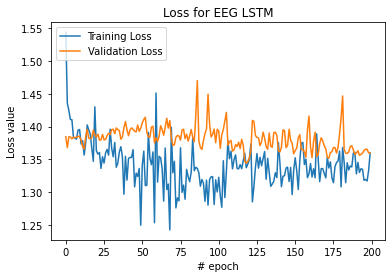

In [642]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss for EEG LSTM')
plt.ylabel('Loss value')
plt.xlabel('# epoch')
plt.legend(loc="upper left")
plt.show()

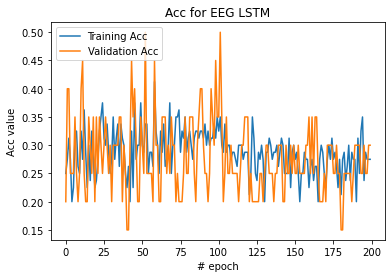

In [643]:
plt.plot(history.history['acc'], label='Training Acc')
plt.plot(history.history['val_acc'], label='Validation Acc')
plt.title('Acc for EEG LSTM')
plt.ylabel('Acc value')
plt.xlabel('# epoch')
plt.legend(loc="upper left")
plt.show()

In [105]:
model.load_weights(f"models\Best")

In [24]:
train_x.shape

(337, 12, 128)

In [34]:
pred = model.predict(train_x[0].reshape(-1, train_x.shape[1], train_x.shape[2]))

In [35]:
pred

array([[3.3189676e-04, 4.2085871e-03, 6.9821896e-03, 2.4181621e-03,
        2.3798265e-04, 2.1329962e-03, 5.0884534e-02, 6.4253420e-02,
        8.6855030e-01]], dtype=float32)

In [36]:
np.argmax(pred)

8

In [37]:
train_y[:10]

array([8, 7, 1, 2, 1, 1, 6, 1, 3, 7])

In [185]:
model.save_weights('models\model.h5')
model_json = model.to_json()
with open('models\model.json', "w") as json_file:
    json_file.write(model_json)